# Exploratory Data Analysis: Lower Layer Super Output Areas (LSOAs)

This notebook presents an exploratory analysis of Lower Layer Super Output Areas (LSOAs), standardised small-area statistical geographies in the UK. The aim is to examine and prepare LSOA boundary data alongside deprivation indices—specifically, the Index of Multiple Deprivation (IMD)—to support public health modelling and application development.

## Objectives

- Load authoritative LSOA boundary data from UK ONS sources.
- Integrate spatial boundaries with IMD statistics (2019).
- Generate summary statistics and spatial visualisations.
- Export merged data for use in downstream applications.


In [25]:
import os
import warnings

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import fiona

# Configure plotting and warnings
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")


In [26]:
import sys
import numpy
import pandas
import geopandas
print(f"Python Executable (Current Notebook): {sys.executable}")
print(f"NumPy version: {numpy.__version__}")
print(f"Pandas version: {pandas.__version__}")
print(f"GeoPandas version: {geopandas.__version__}")

Python Executable (Current Notebook): /opt/anaconda3/envs/Research_Project_-_Geospatial_Health_Demand/bin/python
NumPy version: 1.26.4
Pandas version: 2.2.3
GeoPandas version: 1.0.1


In [5]:
# Define data paths
shp_path = "../data/raw/Lower_layer_Super_Output_Areas_(December_2021)_Boundaries_EW_BFC_(V10).shp"
imd_path = "../data/raw/Index_of_Multiple_Deprivation_(Dec_2019)_Lookup_in_England.csv"
nhs_regions_path = "../data/raw/NHS_England_(Regions)_(December_2023)_EN_BGC.shp"
lookup_path = "../data/raw/LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District_(2022)_Exact_Fit_Lookup_for_EW_(V3).csv"





In [6]:
# Load NHS regions shapefile and filter South West
nhs_gdf = gpd.read_file(nhs_regions_path)
sw_region = nhs_gdf[nhs_gdf["NHSER23NM"] == "South West"]

print(f"Loaded {len(sw_region)} region(s) for NHS South West.")
print(sw_region[['NHSER23CD', 'NHSER23NM']].drop_duplicates())


Loaded 1 region(s) for NHS South West.
   NHSER23CD   NHSER23NM
2  E40000006  South West


In [7]:
# Load 2021 LSOA boundaries from shapefile
lsoa_gdf = gpd.read_file(shp_path)

# Reproject if needed
if lsoa_gdf.crs != sw_region.crs:
    lsoa_gdf = lsoa_gdf.to_crs(sw_region.crs)

# Clip to South West region
lsoa_sw = gpd.clip(lsoa_gdf, sw_region)

print(f"LSOAs in NHS South West region: {len(lsoa_sw)}")


LSOAs in NHS South West region: 3476


In [8]:
# Load Index of Multiple Deprivation (2019) data
imd_df = pd.read_csv(imd_path)

# Ensure columns are clean and standardised
imd_df['LSOA11CD'] = imd_df['LSOA11CD'].astype(str).str.strip()
lsoa_sw['LSOA21CD'] = lsoa_sw['LSOA21CD'].astype(str).str.strip()

# Rename for consistency
imd_df = imd_df.rename(columns={'LSOA11CD': 'LSOA21CD', 'IMD19': 'IMD_Rank'})

# Merge with spatial data
lsoa_sw = lsoa_sw.merge(imd_df[['LSOA21CD', 'IMD_Rank']], on='LSOA21CD', how='left')

# Diagnostic: check merge coverage
missing_count = lsoa_sw['IMD_Rank'].isna().sum()
print(f"Missing IMD scores after initial merge: {missing_count}")


Missing IMD scores after initial merge: 246


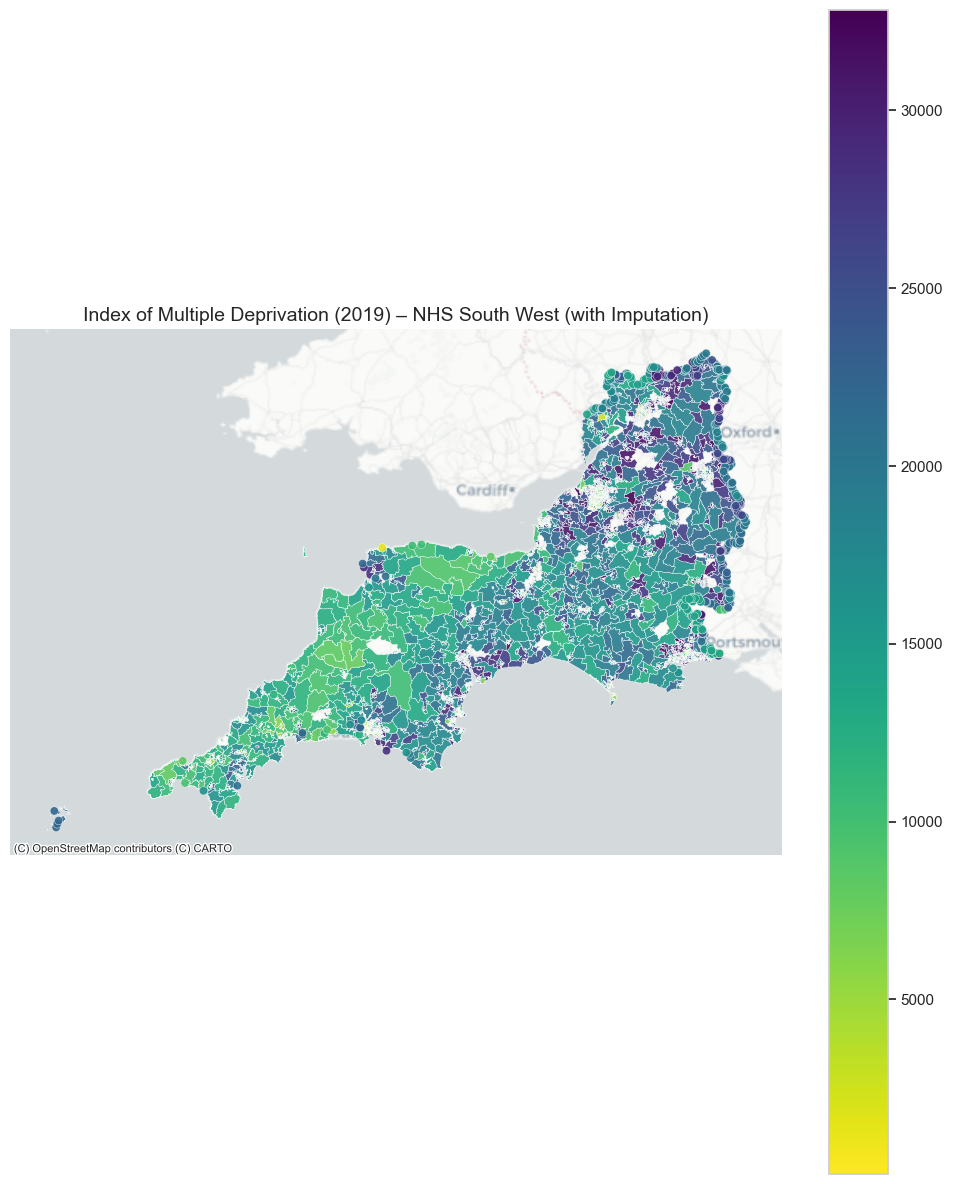

In [9]:
# Visualise final IMD distribution in NHS South West
fig, ax = plt.subplots(figsize=(10, 12))
lsoa_sw.plot(
    ax=ax,
    column='IMD_Rank',
    cmap='viridis_r',
    legend=True,
    edgecolor='white',
    linewidth=0.3,
    alpha=0.9
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=lsoa_sw.crs)
ax.set_title("Index of Multiple Deprivation (2019) – NHS South West (with Imputation)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


In [10]:
# Load the full LSOA to LAD lookup
lookup_df = pd.read_csv(lookup_path)[['LSOA21CD', 'LAD22CD', 'LAD22NM']].dropna()
lookup_df = lookup_df.astype(str)

# Merge to append LAD info
lsoa_sw = lsoa_sw.merge(lookup_df, on='LSOA21CD', how='left')

# Diagnostic
print(f"Unique Local Authority Districts (LADs) in South West: {lsoa_sw['LAD22NM'].nunique()}")


Unique Local Authority Districts (LADs) in South West: 40


In [12]:
# Compute average IMD per LAD
lad_summary = (
    lsoa_sw
    .groupby('LAD22NM')['IMD_Rank']
    .mean()
    .reset_index()
    .sort_values(by='IMD_Rank')
)

# Display bottom 10 (most deprived)
print("10 Most Deprived LADs (lowest average IMD rank):")
print(lad_summary.head(10))



10 Most Deprived LADs (lowest average IMD rank):
                      LAD22NM      IMD_Rank
32                     Torbay  11888.011494
33                   Torridge  12969.722222
20                   Plymouth  13243.981013
4                    Cornwall  13279.914013
2            Bristol, City of  13528.054054
18                North Devon  15388.894737
21                  Sedgemoor  15524.863636
13              Malvern Hills  16209.500000
10                 Gloucester  16518.635135
22  Somerset West and Taunton  16548.247059


In [13]:
# Display top 10 (least deprived)
print("\n10 Least Deprived LADs (highest average IMD rank):")
print(lad_summary.tail(10).sort_values(by='IMD_Rank', ascending=False))



10 Least Deprived LADs (highest average IMD rank):
                         LAD22NM      IMD_Rank
34           Vale of White Horse  27935.500000
27                        Stroud  24201.090909
5                       Cotswold  23549.347826
0   Bath and North East Somerset  23382.044643
23         South Gloucestershire  23304.879747
31                    Tewkesbury  23134.644444
39                      Wychavon  22938.500000
37              West Oxfordshire  22545.200000
12               Isles of Scilly  22165.000000
16                 Monmouthshire           NaN


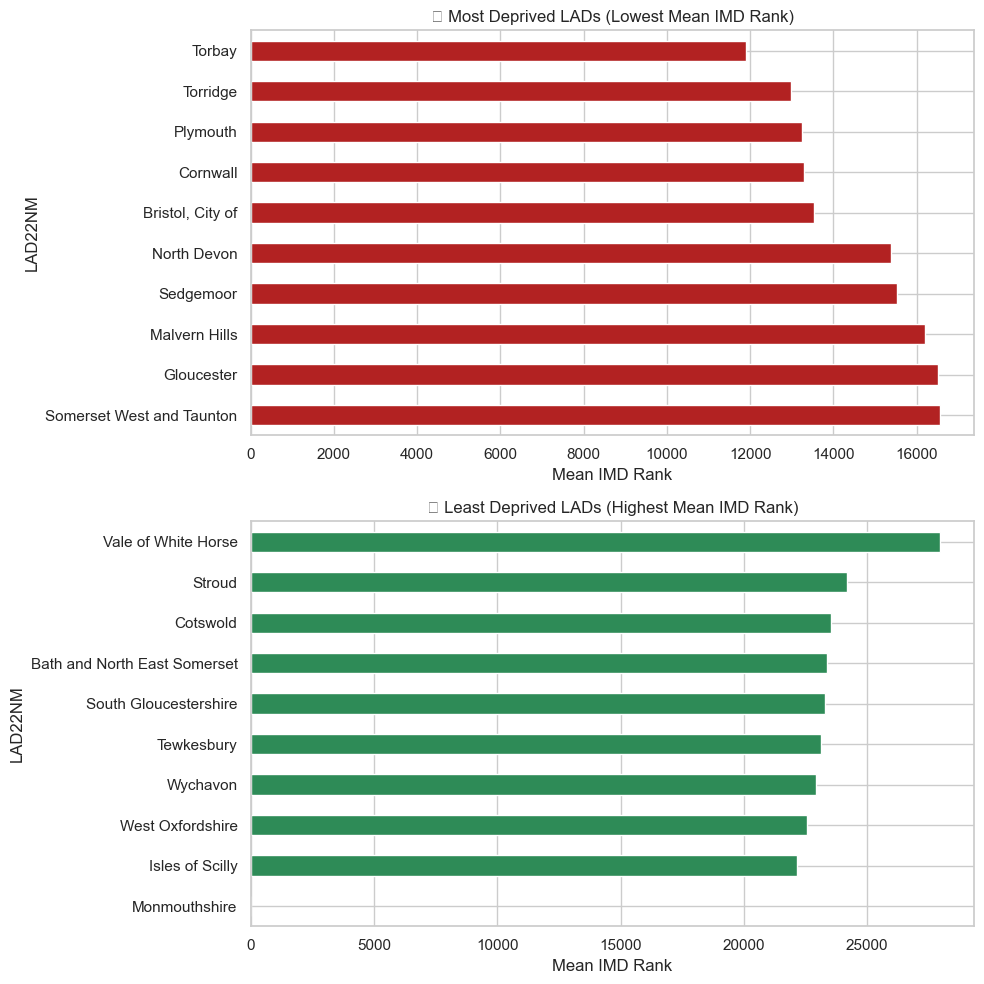

In [14]:
# Visualise top and bottom 10
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=False)

# Bottom 10
lad_summary.head(10).plot.barh(
    x='LAD22NM', y='IMD_Rank',
    ax=ax[0], color='firebrick', legend=False
)
ax[0].set_title("🔻 Most Deprived LADs (Lowest Mean IMD Rank)", fontsize=12)
ax[0].invert_yaxis()
ax[0].set_xlabel("Mean IMD Rank")

# Top 10
lad_summary.tail(10).sort_values(by='IMD_Rank', ascending=False).plot.barh(
    x='LAD22NM', y='IMD_Rank',
    ax=ax[1], color='seagreen', legend=False
)
ax[1].set_title("🔺 Least Deprived LADs (Highest Mean IMD Rank)", fontsize=12)
ax[1].invert_yaxis()
ax[1].set_xlabel("Mean IMD Rank")

plt.tight_layout()
plt.show()


In [15]:
# Load the rural-urban classification lookup
ruc_path = "../data/raw/Rural_Urban_Classification_(2021)_of_LSOAs_in_EW.csv"
ruc_df = pd.read_csv(ruc_path)

# Show column names and unique values
print("Columns:", ruc_df.columns.tolist())
print("\nSample:")
print(ruc_df.head())

# Set the full classification column explicitly
ruc_class_col = 'RUC21NM'  # full category like 'Urban: Nearer...'
binary_flag_col = 'Urban_rural_flag'  # optional: simple Urban/Rural

# Check distribution
print("\nRural–Urban Full Types:")
print(ruc_df[ruc_class_col].value_counts())

print("\nBinary Urban/Rural Flag:")
print(ruc_df[binary_flag_col].value_counts())



Columns: ['LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'RUC21CD', 'RUC21NM', 'Urban_rural_flag', 'ObjectId']

Sample:
    LSOA21CD                   LSOA21NM LSOA21NMW RUC21CD  \
0  E01000001        City of London 001A       NaN     UN1   
1  E01000002        City of London 001B       NaN     UN1   
2  E01000003        City of London 001C       NaN     UN1   
3  E01000005        City of London 001E       NaN     UN1   
4  E01000006  Barking and Dagenham 016A       NaN     UN1   

                                 RUC21NM Urban_rural_flag  ObjectId  
0  Urban: Nearer to a major town or city            Urban         1  
1  Urban: Nearer to a major town or city            Urban         2  
2  Urban: Nearer to a major town or city            Urban         3  
3  Urban: Nearer to a major town or city            Urban         4  
4  Urban: Nearer to a major town or city            Urban         5  

Rural–Urban Full Types:
RUC21NM
Urban: Nearer to a major town or city               27106
Urban: Furth

In [16]:
# Ensure merge keys are strings
ruc_df['LSOA21CD'] = ruc_df['LSOA21CD'].astype(str).str.strip()
lsoa_sw['LSOA21CD'] = lsoa_sw['LSOA21CD'].astype(str).str.strip()

# Merge RUC onto South West LSOAs
lsoa_sw = lsoa_sw.merge(
    ruc_df[['LSOA21CD', ruc_class_col, binary_flag_col]],
    on='LSOA21CD',
    how='left'
)

# Check missing RUC assignments
print(f"Missing RUC entries after merge: {lsoa_sw[ruc_class_col].isna().sum()}")


Missing RUC entries after merge: 0


In [17]:
# Count of LSOAs by Urban/Rural classification within each LAD
lad_urban_rural_counts = (
    lsoa_sw
    .groupby(['LAD22NM', 'Urban_rural_flag'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# Calculate percentage for each Urban/Rural category within each LAD
lad_urban_rural_percentage = lad_urban_rural_counts.div(lad_urban_rural_counts.sum(axis=1), axis=0) * 100

# Combine counts and percentages into one table
lad_urban_rural_combined = pd.concat([lad_urban_rural_counts, lad_urban_rural_percentage], axis=1)
lad_urban_rural_combined.columns = [
    'Urban Count', 'Rural Count', 'Urban Percentage', 'Rural Percentage'
]

# Calculate the Rural to Urban ratio (Rural / Urban) with handling for 0 Urban count
lad_urban_rural_combined['Rural to Urban Ratio'] = lad_urban_rural_combined.apply(
    lambda row: row['Rural Count'] / row['Urban Count'] if row['Urban Count'] > 0 else 'Undefined',
    axis=1
)

# Display the final table with counts, percentages, and ratio
print("Urban/Rural LSOA Counts, Percentages, and Rural to Urban Ratio per LAD:")
display(lad_urban_rural_combined)


Urban/Rural LSOA Counts, Percentages, and Rural to Urban Ratio per LAD:


,Urban Count,Rural Count,Urban Percentage,Rural Percentage,Rural to Urban Ratio
LAD22NM,,,,,
Bath and North East Somerset,29,89,24.576271,75.423729,3.068966
"Bournemouth, Christchurch and Poole",4,236,1.666667,98.333333,59.0
"Bristol, City of",0,268,0.000000,100.000000,Undefined
Cheltenham,0,77,0.000000,100.000000,Undefined
Cornwall,184,153,54.599407,45.400593,0.831522
Cotswold,43,13,76.785714,23.214286,0.302326
Dorset,101,123,45.089286,54.910714,1.217822
East Devon,46,42,52.272727,47.727273,0.913043
Exeter,0,78,0.000000,100.000000,Undefined


In [18]:
# Mean IMD score per LAD and Urban/Rural category
lad_ruc_imd = (
    lsoa_sw
    .groupby(['LAD22NM', 'Urban_rural_flag'])['IMD_Rank']
    .mean()
    .unstack()
    .round(1)
)

print("Mean IMD Rank by Urban/Rural per LAD:")
display(lad_ruc_imd)


Mean IMD Rank by Urban/Rural per LAD:


Urban_rural_flag,Rural,Urban
LAD22NM,,
Bath and North East Somerset,25022.5,22861.0
"Bournemouth, Christchurch and Poole",29356.8,18284.0
"Bristol, City of",NaN,13528.1
Cheltenham,NaN,21795.5
Cornwall,13371.7,13162.9
Cotswold,23977.5,22462.5
Dorset,18492.9,20692.8
East Devon,22818.0,21385.3
Exeter,NaN,19229.7


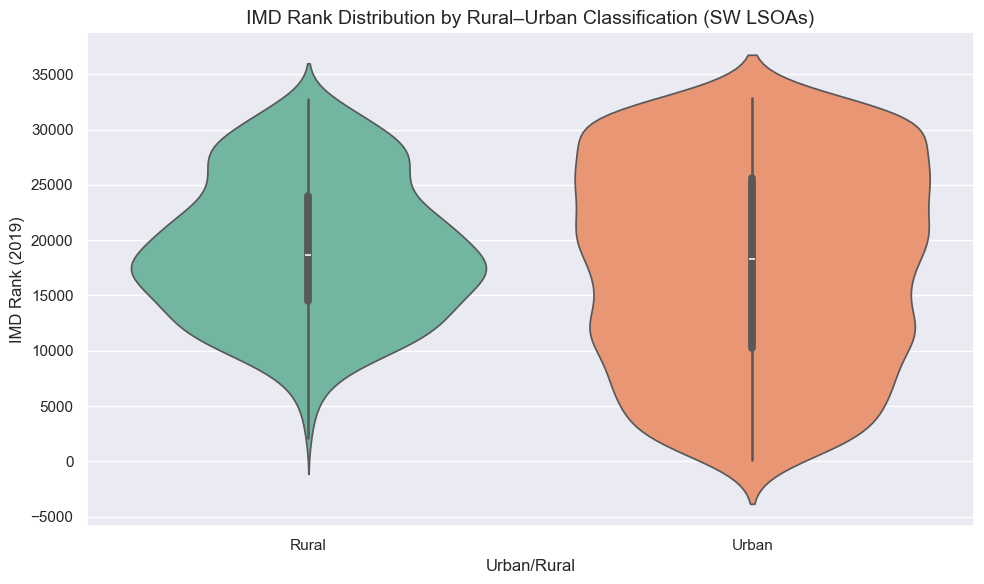

In [19]:

fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(
    data=lsoa_sw,
    x='Urban_rural_flag',
    y='IMD_Rank',
    inner='box',
    palette='Set2',
    ax=ax
)
ax.set_title("IMD Rank Distribution by Rural–Urban Classification (SW LSOAs)", fontsize=14)
ax.set_xlabel("Urban/Rural")
ax.set_ylabel("IMD Rank (2019)")
plt.tight_layout()
plt.show()


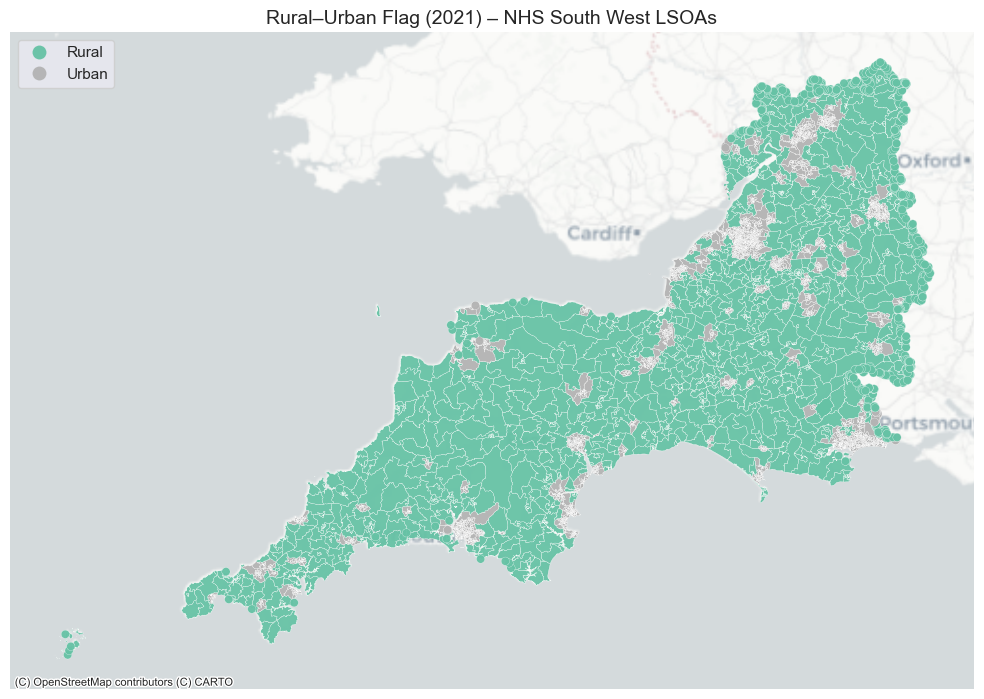

In [20]:
fig, ax = plt.subplots(figsize=(10, 12))

lsoa_sw.plot(
    ax=ax,
    column='Urban_rural_flag',
    legend=True,
    cmap='Set2',
    edgecolor='white',
    linewidth=0.2,
    alpha=0.95
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=lsoa_sw.crs)
ax.set_title("Rural–Urban Flag (2021) – NHS South West LSOAs", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


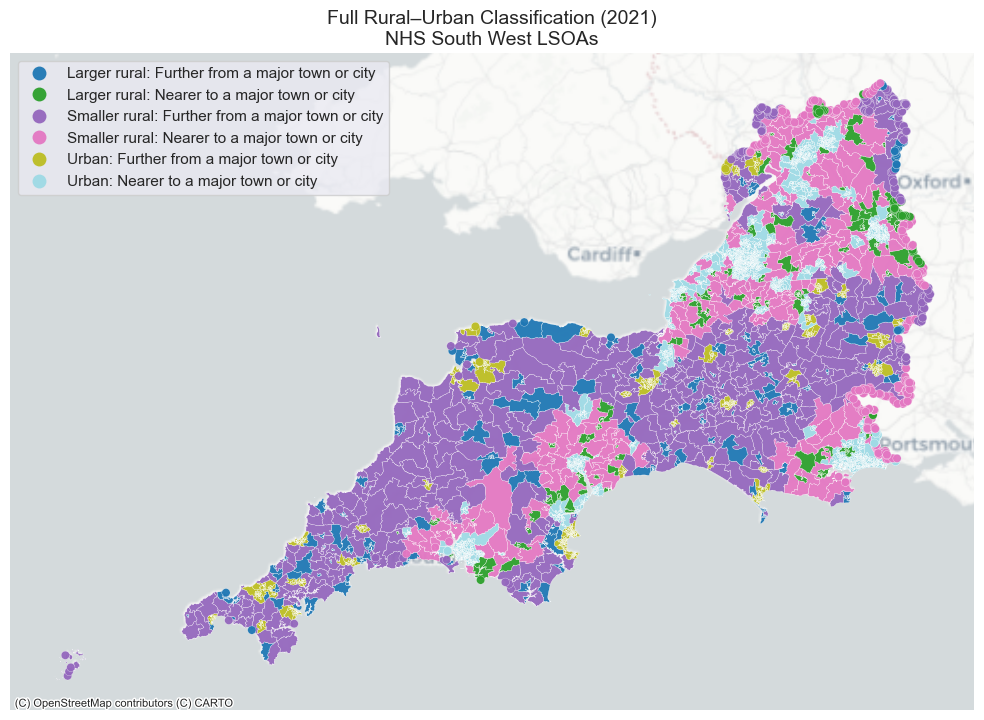

In [21]:
fig, ax = plt.subplots(figsize=(10, 12))

lsoa_sw.plot(
    ax=ax,
    column='RUC21NM',
    legend=True,
    cmap='tab20',
    edgecolor='white',
    linewidth=0.2,
    alpha=0.95
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=lsoa_sw.crs)
ax.set_title("Full Rural–Urban Classification (2021)\nNHS South West LSOAs", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


In [27]:
# Define the path for the new lookup file
icb_lookup_path = "../data/raw/LSOA_(2021)_to_SICBL_to_ICB_to_LAD_(April_2023)_Lookup_in_EN.csv"

# Load the lookup table
try:
    icb_lookup_df = pd.read_csv(icb_lookup_path)
    print(f"Successfully loaded lookup file: {icb_lookup_path}")
    print(f"Shape of the lookup table: {icb_lookup_df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {icb_lookup_path}")
    # Handle the error appropriately, e.g., exit or skip subsequent steps
    icb_lookup_df = None  # Set to None to avoid errors in subsequent cells if file not found

if icb_lookup_df is not None:
    # Display basic info about the lookup table
    print("\nLookup Table Info:")
    icb_lookup_df.info()

    print("\nFirst 5 rows of the lookup table:")
    display(icb_lookup_df.head())

    print("\nColumns in the lookup table:")
    print(icb_lookup_df.columns.tolist())

    print("\nMissing values per column:")
    print(icb_lookup_df.isna().sum())

Successfully loaded lookup file: ../data/raw/LSOA_(2021)_to_SICBL_to_ICB_to_LAD_(April_2023)_Lookup_in_EN.csv
Shape of the lookup table: (33755, 11)

Lookup Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33755 entries, 0 to 33754
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   LSOA21CD    33755 non-null  object
 1   LSOA21NM    33755 non-null  object
 2   SICBL23CD   33755 non-null  object
 3   SICBL23CDH  33755 non-null  object
 4   SICBL23NM   33755 non-null  object
 5   ICB23CD     33755 non-null  object
 6   ICB23CDH    33755 non-null  object
 7   ICB23NM     33755 non-null  object
 8   LAD23CD     33755 non-null  object
 9   LAD23NM     33755 non-null  object
 10  ObjectId    33755 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 2.8+ MB

First 5 rows of the lookup table:


,LSOA21CD,LSOA21NM,SICBL23CD,SICBL23CDH,SICBL23NM,ICB23CD,ICB23CDH,ICB23NM,LAD23CD,LAD23NM,ObjectId
0,E01011954,Hartlepool 001A,E38000247,16C,NHS North East and North Cumbria ICB - 16C,E54000050,QHM,NHS North East and North Cumbria Integrated Ca...,E06000001,Hartlepool,1
1,E01011969,Hartlepool 001B,E38000247,16C,NHS North East and North Cumbria ICB - 16C,E54000050,QHM,NHS North East and North Cumbria Integrated Ca...,E06000001,Hartlepool,2
2,E01011970,Hartlepool 001C,E38000247,16C,NHS North East and North Cumbria ICB - 16C,E54000050,QHM,NHS North East and North Cumbria Integrated Ca...,E06000001,Hartlepool,3
3,E01011971,Hartlepool 001D,E38000247,16C,NHS North East and North Cumbria ICB - 16C,E54000050,QHM,NHS North East and North Cumbria Integrated Ca...,E06000001,Hartlepool,4
4,E01033465,Hartlepool 001F,E38000247,16C,NHS North East and North Cumbria ICB - 16C,E54000050,QHM,NHS North East and North Cumbria Integrated Ca...,E06000001,Hartlepool,5



Columns in the lookup table:
['LSOA21CD', 'LSOA21NM', 'SICBL23CD', 'SICBL23CDH', 'SICBL23NM', 'ICB23CD', 'ICB23CDH', 'ICB23NM', 'LAD23CD', 'LAD23NM', 'ObjectId']

Missing values per column:
LSOA21CD      0
LSOA21NM      0
SICBL23CD     0
SICBL23CDH    0
SICBL23NM     0
ICB23CD       0
ICB23CDH      0
ICB23NM       0
LAD23CD       0
LAD23NM       0
ObjectId      0
dtype: int64


In [28]:
# --- Data Cleaning and Preparation ---

if icb_lookup_df is not None:
    # Standardise the LSOA code column for merging
    # Ensure it's string type and remove leading/trailing whitespace
    icb_lookup_df['LSOA21CD'] = icb_lookup_df['LSOA21CD'].astype(str).str.strip()

    # Select relevant columns (Codes and Names for ICB, SICBL, LAD)
    # Note: The LAD columns here are from April 2023, whereas the previous lookup used 2022.
    # We might keep both or decide which one to use consistently later.
    relevant_cols = [
        'LSOA21CD',
        'SICBL23CD', 'SICBL23NM',  # Sub ICB Location Code & Name (April 2023)
        'ICB23CD', 'ICB23NM',  # ICB Code & Name (April 2023)
        'LAD23CD', 'LAD23NM'  # Local Authority District Code & Name (April 2023)
    ]
    icb_lookup_subset = icb_lookup_df[relevant_cols].copy()

    # Check for duplicates based on LSOA code - there should ideally be only one entry per LSOA
    duplicates = icb_lookup_subset[icb_lookup_subset.duplicated(subset=['LSOA21CD'], keep=False)]
    if not duplicates.empty:
        print(f"\nWarning: Found {len(duplicates)} duplicate LSOA21CD entries in the lookup table.")
        # display(duplicates.head()) # Optionally display duplicates
        # Decide on a strategy: drop duplicates, keep first/last, investigate further
        icb_lookup_subset = icb_lookup_subset.drop_duplicates(subset=['LSOA21CD'], keep='first')
        print("Dropped duplicate LSOA21CD entries, keeping the first occurrence.")
    else:
        print("\nNo duplicate LSOA21CD entries found in the lookup table.")

    print(f"\nShape of the cleaned lookup subset: {icb_lookup_subset.shape}")
    display(icb_lookup_subset.head())


No duplicate LSOA21CD entries found in the lookup table.

Shape of the cleaned lookup subset: (33755, 7)


,LSOA21CD,SICBL23CD,SICBL23NM,ICB23CD,ICB23NM,LAD23CD,LAD23NM
0,E01011954,E38000247,NHS North East and North Cumbria ICB - 16C,E54000050,NHS North East and North Cumbria Integrated Ca...,E06000001,Hartlepool
1,E01011969,E38000247,NHS North East and North Cumbria ICB - 16C,E54000050,NHS North East and North Cumbria Integrated Ca...,E06000001,Hartlepool
2,E01011970,E38000247,NHS North East and North Cumbria ICB - 16C,E54000050,NHS North East and North Cumbria Integrated Ca...,E06000001,Hartlepool
3,E01011971,E38000247,NHS North East and North Cumbria ICB - 16C,E54000050,NHS North East and North Cumbria Integrated Ca...,E06000001,Hartlepool
4,E01033465,E38000247,NHS North East and North Cumbria ICB - 16C,E54000050,NHS North East and North Cumbria Integrated Ca...,E06000001,Hartlepool


In [29]:
# --- Merge with South West LSOA Data ---

if 'lsoa_sw' in locals() and icb_lookup_df is not None:  # Check if lsoa_sw exists
    print(f"Shape of lsoa_sw before merging: {lsoa_sw.shape}")
    print(f"Columns in lsoa_sw before merging: {lsoa_sw.columns.tolist()}")

    # Ensure the merge key in lsoa_sw is also string type
    lsoa_sw['LSOA21CD'] = lsoa_sw['LSOA21CD'].astype(str).str.strip()

    # Perform the merge
    lsoa_sw = lsoa_sw.merge(
        icb_lookup_subset,
        on='LSOA21CD',
        how='left'  # Keep all LSOAs in the South West set
    )

    print(f"\nShape of lsoa_sw after merging: {lsoa_sw.shape}")
    print(f"Columns in lsoa_sw after merging: {lsoa_sw.columns.tolist()}")

    # --- Post-Merge Diagnostics ---
    print("\nChecking for missing values in newly merged columns:")
    new_cols = ['SICBL23CD', 'SICBL23NM', 'ICB23CD', 'ICB23NM', 'LAD23CD', 'LAD23NM']
    print(lsoa_sw[new_cols].isna().sum())

    # Compare LAD22NM and LAD23NM if both exist
    if 'LAD22NM' in lsoa_sw.columns and 'LAD23NM' in lsoa_sw.columns:
        lad_comparison = lsoa_sw[lsoa_sw['LAD22NM'] != lsoa_sw['LAD23NM']][['LSOA21CD', 'LAD22NM', 'LAD23NM']].dropna()
        if not lad_comparison.empty:
            print(f"\nFound {len(lad_comparison)} LSOAs where LAD22NM and LAD23NM differ:")
            display(lad_comparison.head())
        else:
            print("\nLAD22NM and LAD23NM match for all LSOAs where both are present.")
        # Optional: Decide which LAD column to keep or rename for consistency
        # Example: lsoa_sw = lsoa_sw.rename(columns={'LAD23NM': 'LADNM', 'LAD23CD': 'LADCD'}).drop(columns=['LAD22NM', 'LAD22CD'])

    print("\nFirst 5 rows of lsoa_sw after merge:")
    display(lsoa_sw.head())

else:
    if 'lsoa_sw' not in locals():
        print("\nSkipping merge: 'lsoa_sw' GeoDataFrame not found.")
    if icb_lookup_df is None:
        print("\nSkipping merge: ICB lookup DataFrame not loaded.")

Shape of lsoa_sw before merging: (3479, 17)
Columns in lsoa_sw before merging: ['FID', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LONG', 'Shape__Are', 'Shape__Len', 'GlobalID', 'geometry', 'IMD_Rank', 'LAD22CD', 'LAD22NM', 'RUC21NM', 'Urban_rural_flag']

Shape of lsoa_sw after merging: (3479, 23)
Columns in lsoa_sw after merging: ['FID', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LONG', 'Shape__Are', 'Shape__Len', 'GlobalID', 'geometry', 'IMD_Rank', 'LAD22CD', 'LAD22NM', 'RUC21NM', 'Urban_rural_flag', 'SICBL23CD', 'SICBL23NM', 'ICB23CD', 'ICB23NM', 'LAD23CD', 'LAD23NM']

Checking for missing values in newly merged columns:
SICBL23CD    2
SICBL23NM    2
ICB23CD      2
ICB23NM      2
LAD23CD      2
LAD23NM      2
dtype: int64

Found 340 LSOAs where LAD22NM and LAD23NM differ:


,LSOA21CD,LAD22NM,LAD23NM
927,E01029174,South Somerset,Somerset
928,E01029175,South Somerset,Somerset
929,E01029177,South Somerset,Somerset
930,E01029171,South Somerset,Somerset
960,E01035132,Somerset West and Taunton,Somerset



First 5 rows of lsoa_sw after merge:


,FID,LSOA21CD,LSOA21NM,LSOA21NMW,BNG_E,BNG_N,LAT,LONG,Shape__Are,Shape__Len,...,LAD22CD,LAD22NM,RUC21NM,Urban_rural_flag,SICBL23CD,SICBL23NM,ICB23CD,ICB23NM,LAD23CD,LAD23NM
0,18094,E01019077,Isles of Scilly 001A,None,91327,11447,49.92333,-6.30217,1.631775e+07,117979.580105,...,E06000053,Isles of Scilly,Smaller rural: Further from a major town or city,Rural,E38000089,NHS Cornwall and the Isles of Scilly ICB - 11N,E54000036,NHS Cornwall and the Isles of Scilly Integrate...,E06000053,Isles of Scilly
1,17905,E01018881,Cornwall 073A,None,171209,15863,49.99891,-5.19393,2.932218e+07,35626.514802,...,E06000052,Cornwall,Smaller rural: Further from a major town or city,Rural,E38000089,NHS Cornwall and the Isles of Scilly ICB - 11N,E54000036,NHS Cornwall and the Isles of Scilly Integrate...,E06000052,Cornwall
2,17928,E01018904,Cornwall 073D,None,168845,17263,50.01057,-5.22770,2.027198e+07,36002.705917,...,E06000052,Cornwall,Larger rural: Further from a major town or city,Rural,E38000089,NHS Cornwall and the Isles of Scilly ICB - 11N,E54000036,NHS Cornwall and the Isles of Scilly Integrate...,E06000052,Cornwall
3,17944,E01018920,Cornwall 073E,None,176727,20597,50.04352,-5.11981,4.172823e+07,41850.955404,...,E06000052,Cornwall,Smaller rural: Further from a major town or city,Rural,E38000089,NHS Cornwall and the Isles of Scilly ICB - 11N,E54000036,NHS Cornwall and the Isles of Scilly Integrate...,E06000052,Cornwall
4,17927,E01018903,Cornwall 073C,None,167518,23383,50.06501,-5.24990,3.123392e+07,34379.444471,...,E06000052,Cornwall,Smaller rural: Further from a major town or city,Rural,E38000089,NHS Cornwall and the Isles of Scilly ICB - 11N,E54000036,NHS Cornwall and the Isles of Scilly Integrate...,E06000052,Cornwall



Number of LSOAs per Integrated Care Board (ICB) in South West:


ICB23NM
NHS Bath and North East Somerset, Swindon and Wiltshire Integrated Care Board    569
NHS Bristol, North Somerset and South Gloucestershire Integrated Care Board      581
NHS Buckinghamshire, Oxfordshire and Berkshire West Integrated Care Board         11
NHS Cornwall and the Isles of Scilly Integrated Care Board                       338
NHS Coventry and Warwickshire Integrated Care Board                                5
NHS Devon Integrated Care Board                                                  729
NHS Dorset Integrated Care Board                                                 464
NHS Gloucestershire Integrated Care Board                                        393
NHS Hampshire and Isle of Wight Integrated Care Board                             25
NHS Herefordshire and Worcestershire Integrated Care Board                        22
NHS Somerset Integrated Care Board                                               340
Name: count, dtype: int64


Number of LSOAs per Sub ICB Location (SICBL) in South West:


SICBL23NM,"NHS Bath and North East Somerset, Swindon and Wiltshire ICB - 92G","NHS Bristol, North Somerset and South Gloucestershire ICB - 15C","NHS Buckinghamshire, Oxfordshire and Berkshire West ICB - 10Q","NHS Buckinghamshire, Oxfordshire and Berkshire West ICB - 15A",NHS Cornwall and the Isles of Scilly ICB - 11N,NHS Coventry and Warwickshire ICB - B2M3M,NHS Devon ICB - 15N,NHS Dorset ICB - 11J,NHS Gloucestershire ICB - 11M,NHS Hampshire and Isle of Wight ICB - D9Y0V,NHS Herefordshire and Worcestershire ICB - 18C,NHS Somerset ICB - 11X
ICB23NM,,,,,,,,,,,,
"NHS Bath and North East Somerset, Swindon and Wiltshire Integrated Care Board",569,0,0,0,0,0,0,0,0,0,0,0
"NHS Bristol, North Somerset and South Gloucestershire Integrated Care Board",0,581,0,0,0,0,0,0,0,0,0,0
"NHS Buckinghamshire, Oxfordshire and Berkshire West Integrated Care Board",0,0,7,4,0,0,0,0,0,0,0,0
NHS Cornwall and the Isles of Scilly Integrated Care Board,0,0,0,0,338,0,0,0,0,0,0,0
NHS Coventry and Warwickshire Integrated Care Board,0,0,0,0,0,5,0,0,0,0,0,0
NHS Devon Integrated Care Board,0,0,0,0,0,0,729,0,0,0,0,0
NHS Dorset Integrated Care Board,0,0,0,0,0,0,0,464,0,0,0,0
NHS Gloucestershire Integrated Care Board,0,0,0,0,0,0,0,0,393,0,0,0
NHS Hampshire and Isle of Wight Integrated Care Board,0,0,0,0,0,0,0,0,0,25,0,0



Average IMD Rank per ICB in South West:


,ICB23NM,IMD_Rank
0,NHS Cornwall and the Isles of Scilly Integrate...,13308.120635
1,NHS Devon Integrated Care Board,16550.097242
2,NHS Somerset Integrated Care Board,17032.249201
3,"NHS Bristol, North Somerset and South Gloucest...",18149.663024
4,NHS Dorset Integrated Care Board,19073.851598
5,NHS Hampshire and Isle of Wight Integrated Car...,19716.480000
6,NHS Herefordshire and Worcestershire Integrate...,20024.681818
7,NHS Coventry and Warwickshire Integrated Care ...,20191.000000
8,NHS Gloucestershire Integrated Care Board,20829.655367
9,"NHS Bath and North East Somerset, Swindon and ...",21183.528376


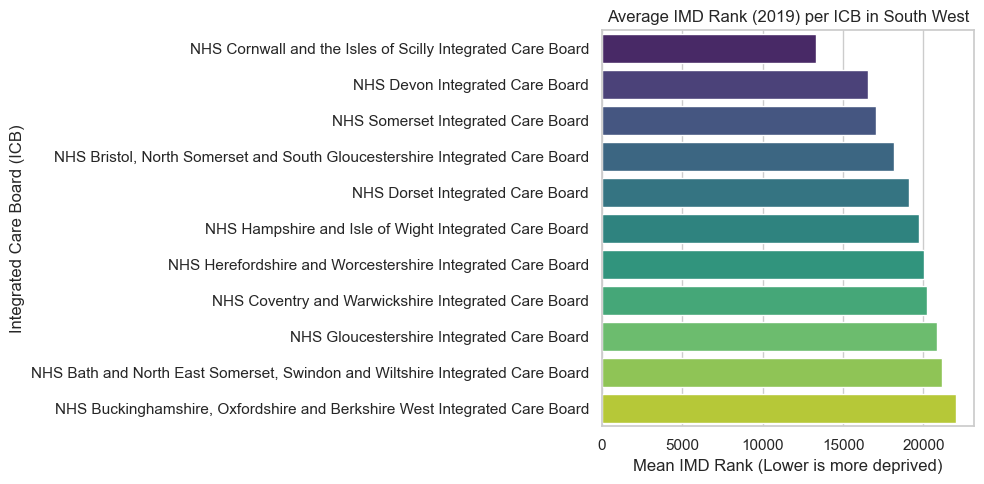

In [30]:
# --- Explore ICB/SICBL relationships within South West ---

if 'lsoa_sw' in locals() and 'ICB23NM' in lsoa_sw.columns:
    # Count LSOAs per ICB in the South West subset
    print("\nNumber of LSOAs per Integrated Care Board (ICB) in South West:")
    icb_counts = lsoa_sw['ICB23NM'].value_counts().sort_index()
    display(icb_counts)

    # Count LSOAs per Sub ICB Location (SICBL) in the South West subset
    print("\nNumber of LSOAs per Sub ICB Location (SICBL) in South West:")
    sicbl_counts = lsoa_sw.groupby(['ICB23NM', 'SICBL23NM']).size().unstack(fill_value=0)
    display(sicbl_counts)

    # Average IMD Rank per ICB
    print("\nAverage IMD Rank per ICB in South West:")
    icb_imd_avg = lsoa_sw.groupby('ICB23NM')['IMD_Rank'].mean().sort_values().reset_index()
    display(icb_imd_avg)

    # Visualize average IMD Rank per ICB
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(data=icb_imd_avg, y='ICB23NM', x='IMD_Rank', palette='viridis', ax=ax)
    ax.set_title('Average IMD Rank (2019) per ICB in South West')
    ax.set_xlabel('Mean IMD Rank (Lower is more deprived)')
    ax.set_ylabel('Integrated Care Board (ICB)')
    plt.tight_layout()
    plt.show()

else:
    print("\nSkipping ICB/SICBL analysis: 'lsoa_sw' or required columns missing.")

Mapping 11 unique ICBs using colormap 'tab20'.


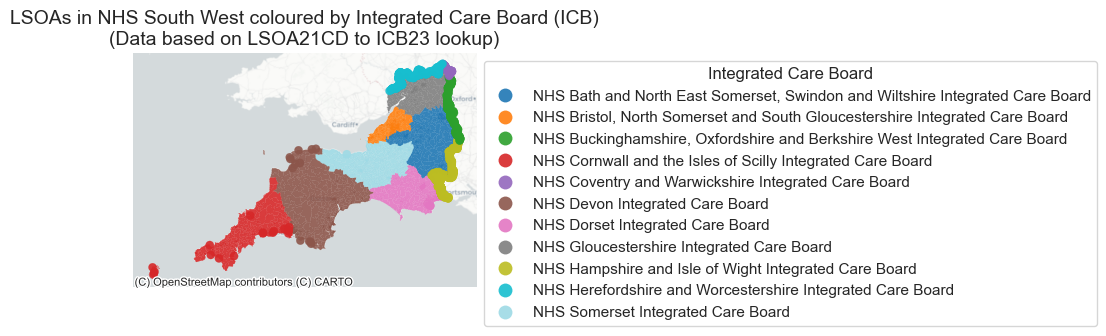

In [31]:
# --- Map LSOAs coloured by Integrated Care Board (ICB) ---

# Check if the necessary GeoDataFrame and column exist
if 'lsoa_sw' in locals() and isinstance(lsoa_sw, gpd.GeoDataFrame) and 'ICB23NM' in lsoa_sw.columns:

    # Check for missing ICB assignments, which might affect plotting
    missing_icb_count = lsoa_sw['ICB23NM'].isna().sum()
    if missing_icb_count > 0:
        print(f"Warning: {missing_icb_count} LSOAs have missing ICB information and may not be coloured correctly.")
        # Optionally, decide how to handle them, e.g., fill with a default value or plot separately
        # For now, they will likely be plotted without color or in a default 'NaN' color.

    # Determine the number of unique ICBs to choose an appropriate colormap
    num_icbs = lsoa_sw['ICB23NM'].nunique()
    # Choose a categorical colormap (e.g., tab10, tab20, Set3, Paired)
    # 'tab10' works for up to 10 categories, 'tab20' for up to 20.
    cmap = 'tab10' if num_icbs <= 10 else 'tab20'
    print(f"Mapping {num_icbs} unique ICBs using colormap '{cmap}'.")

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 12))

    lsoa_sw.plot(
        ax=ax,
        column='ICB23NM',  # Column to determine color
        categorical=True,  # Treat the column as categorical data
        cmap=cmap,  # Use the chosen categorical colormap
        legend=True,  # Add a legend to map colors to ICB names
        legend_kwds={  # Optional keywords to adjust legend
            'title': "Integrated Care Board",
            'loc': 'upper left',
            'bbox_to_anchor': (1, 1)  # Place legend outside plot area slightly
        },
        edgecolor='face',  # Make edges the same color as the face for a cleaner look at this scale
        linewidth=0.1,  # Thin lines between LSOAs
        alpha=0.9  # Slightly transparent
    )

    # Add a basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=lsoa_sw.crs)

    # Set title and turn off axis
    ax.set_title(
        "LSOAs in NHS South West coloured by Integrated Care Board (ICB)\n(Data based on LSOA21CD to ICB23 lookup)",
        fontsize=14)
    ax.axis("off")

    # Adjust layout to prevent labels/legend overlapping
    plt.tight_layout()
    plt.show()

else:
    # Print a message if the required data isn't available
    print("\nSkipping ICB map visualization:")
    if 'lsoa_sw' not in locals() or not isinstance(lsoa_sw, gpd.GeoDataFrame):
        print("- 'lsoa_sw' GeoDataFrame not found or is not a GeoDataFrame.")
    if 'ICB23NM' not in lsoa_sw.columns:
        print("- 'ICB23NM' column not found in lsoa_sw.")